In [107]:
import requests
import re
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag, ne_chunk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

In [108]:
# Initialisation des outils
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('punkt_tab')
nltk.download('maxent_ne_chunker_tab') # Add this line to download the missing resource

nlp = spacy.load("en_core_web_sm")  # spaCy model
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker_tab is already up-to-date!


🔹 1. load_texts() – Télécharger et nettoyer le texte

Objectif : Télécharger les livres depuis les URLs et nettoyer les caractères non pertinents.

In [109]:
def load_texts(urls):
    """
    Télécharger les textes et nettoyer les caractères spéciaux.
    """
    corpus = []

    for url in urls:
        try:
            response = requests.get(url)
            response.raise_for_status()
            text = response.text
            cleaned_text = re.sub(r'[^a-zA-Z\s.,!?;:\'"()-]', '', text)
            corpus.append(cleaned_text)
        except requests.RequestException as e:
            print(f"Erreur : {e}")
            corpus.append("")

    return corpus

➕ Explication débutant :

    requests.get(url) : télécharge le texte du livre depuis Internet.

    re.sub(...) : enlève les caractères bizarres (garde seulement les lettres, la ponctuation).

    Le texte nettoyé est ajouté à une liste appelée corpus.

🔹 2. Afficher les 200 premiers caractères et enlever les parties inutiles

Objectif : Supprimer les introductions et crédits inutiles de Project Gutenberg.

In [110]:
def extract_main_content(texts):
    """
    Supprimer les en-têtes/pieds de page de Project Gutenberg.
    """
    cleaned_texts = []
    for text in texts:
        start = text.find("*** START")
        end = text.find("*** END")
        if start != -1 and end != -1:
            text = text[start + len("*** START"):end]
        cleaned_texts.append(text.strip())
    return cleaned_texts


➕ Explication débutant :

    Le texte des livres contient des crédits et mentions légales avant/après.

    On garde seulement ce qui est entre *** START et *** END.

🔹 3. Tokenisation – Découper le texte en mots

Objectif : Découper les phrases en mots.

In [111]:
def tokenize_texts(texts):
    """
    Tokenisation des textes (mots uniquement).
    """
    tokenized = []
    for text in texts:
        tokens = word_tokenize(text.lower())
        tokens = [token for token in tokens if token.isalpha()]
        tokenized.append(tokens)
    return tokenized


➕ Explication débutant :

    word_tokenize() : découpe le texte en mots (tokens).

    token.isalpha() : garde seulement les mots alphabétiques (pas de chiffres ou symboles).

🔹 4. Suppression des stopwords

Objectif : Enlever les mots inutiles comme "the", "and", "we", "my", etc.

In [112]:
def remove_stopwords(tokenized_texts, language='english'):
    """
    Enlève les mots vides ("stopwords").
    """
    stop_words = set(stopwords.words(language))
    return [[token for token in tokens if token not in stop_words] for tokens in tokenized_texts]


➕ Explication débutant :

    Les stopwords sont des mots fréquents mais pas informatifs.

    Cette étape améliore la qualité de l'analyse (on garde les mots importants).

🔹 5. Stemming – Réduction des mots à leur racine

Objectif : Réduire les mots à leur racine (e.g., "running" → "run").

In [113]:
def stem_tokens(tokenized_texts):
    """
    Réduit les mots à leur racine.
    """
    stemmer = PorterStemmer()
    return [[stemmer.stem(token) for token in tokens] for tokens in tokenized_texts]


➕ Explication débutant :

    Utilise PorterStemmer pour transformer les mots en leur forme de base simplifiée.

🔹 6. Lemmatization – Version plus intelligente du stemming

Objectif : Utiliser spaCy pour faire une lemmatisation plus précise.

In [114]:
def lemmatize_tokens(texts):
    """
    Lemmatise chaque texte avec spaCy.
    """
    lemmatized_texts = []
    for text in texts:
        doc = nlp(text[:1000000])
        tokens = [token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop]
        lemmatized_texts.append(tokens)
    return lemmatized_texts


➕ Explication débutant :

    La lemmatisation tient compte du contexte et de la grammaire.

    Par exemple, "better" devient "good", contrairement au stemming qui le laisse comme "better".

Analyse : Stemming vs Lemmatization

Objectif : Comprendre la différence entre les deux approches.

Stemming: Réduction brute (plus rapide, mais parfois incorrecte).
Lemmatization: Réduction intelligente (plus lente, mais plus précise).

🔹 8. POS Tagging – Identifier la nature des mots

Objectif : Savoir si un mot est un nom, un verbe, un adjectif, etc.

In [115]:
def get_pos_tags(tokenized_texts):
    """
    Retourne les types de mots (nom, verbe, etc.).
    """
    tagged = []
    for tokens in tokenized_texts:
        tagged.append(pos_tag(tokens[:1000]))  # limiter pour rapidité
    return tagged


➕ Explication débutant :

    pos_tag() : indique la fonction grammaticale de chaque mot.

🔹 9. Named Entity Recognition (NER) – Reconnaître les entités nommées

Objectif : Identifier les noms de personnes, lieux, organisations, etc.

In [116]:
def get_entities(texts):
    """
    Extraire les entités nommées.
    """
    from nltk import word_tokenize, pos_tag
    entities_list = []

    for text in texts:
        tokens = word_tokenize(text[:100000])
        tagged = pos_tag(tokens)
        chunks = ne_chunk(tagged)
        entities = []

        for chunk in chunks:
            if hasattr(chunk, 'label'):
                name = ' '.join([token for token, _ in chunk.leaves()])
                entities.append((name, chunk.label()))
        entities_list.append(entities)

    return entities_list


🔹 Analyse visuelle : WordCloud

Objectif : Afficher les mots les plus fréquents avec un nuage de mots.



In [117]:
def create_wordcloud(token_lists, titles):
    """
    Affiche un wordcloud par texte.
    """
    fig, axes = plt.subplots(1, len(token_lists), figsize=(15, 5))

    # Corriger ici : transformer axes en liste s’il n’y a qu’un seul élément
    if len(token_lists) == 1:
        axes = [axes]

    for i, (tokens, title) in enumerate(zip(token_lists, titles)):
        text = ' '.join(tokens)
        wordcloud = WordCloud(width=400, height=300, background_color='white').generate(text)
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].axis('off')
        axes[i].set_title(title, fontsize=12)
    plt.tight_layout()
    plt.show()


➕ Explication débutant :

    Crée une image où la taille des mots reflète leur fréquence dans le texte.

🔹 Bag of Words (BoW)

Objectif : Compter combien de fois chaque mot apparaît.

In [118]:
def get_bow_top_words(texts, top_n=5):
    """
    Renvoie les mots les plus fréquents (BoW) pour chaque texte.
    """
    vectorizer = CountVectorizer()
    matrix = vectorizer.fit_transform(texts)
    words = vectorizer.get_feature_names_out()
    freqs = matrix.toarray() # Get frequencies for each document

    top_words_list = []
    for doc_freqs in freqs:
        top_indices = doc_freqs.argsort()[::-1][:top_n]
        top_words_list.append([(words[i], doc_freqs[i]) for i in top_indices])

    return top_words_list

➕ Explication débutant :

    BoW transforme le texte en matrice de fréquences de mots.

    Les mots les plus fréquents sont extraits (top 5).

🔹 TF-IDF – Fréquence inverse

Objectif : Identifier les mots importants et rares dans chaque livre.

In [119]:
def get_tfidf_top_words(texts, top_n=5):
    """
    Renvoie les mots les plus importants selon TF-IDF pour chaque texte.
    """
    vectorizer = TfidfVectorizer(max_features=1000)
    tfidf = vectorizer.fit_transform(texts)
    words = vectorizer.get_feature_names_out()

    top_words_list = []
    for i in range(len(texts)):
        row = tfidf[i].toarray().flatten()
        top_indices = row.argsort()[::-1][:top_n]
        top_words_list.append([(words[j], row[j]) for j in top_indices])

    return top_words_list

➕ Explication débutant :

    Mots répétés partout → moins importants.

    Mots fréquents dans un seul texte → plus importants.

🔹 Diagrammes circulaires (pie chart)

Objectif : Visualiser les 5 mots les plus importants par livre.


In [120]:
def create_pie_chart(word_freq_pairs, title, method):
    """
    Affiche les mots les plus fréquents ou importants.
    """
    words = [pair[0] for pair in word_freq_pairs]
    freqs = [pair[1] for pair in word_freq_pairs]

    plt.figure(figsize=(7, 5))
    plt.pie(freqs, labels=[f'{w}\n({f:.2f})' for w, f in word_freq_pairs],
            autopct='%1.1f%%', startangle=90)
    plt.title(f'{title} - Top Words ({method})')
    plt.axis('equal')
    plt.show()

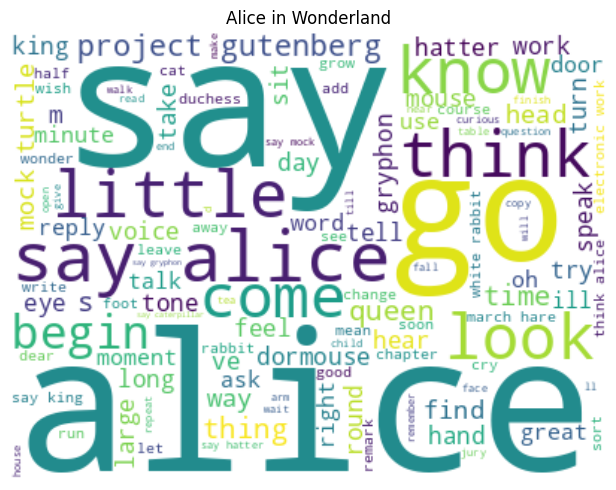

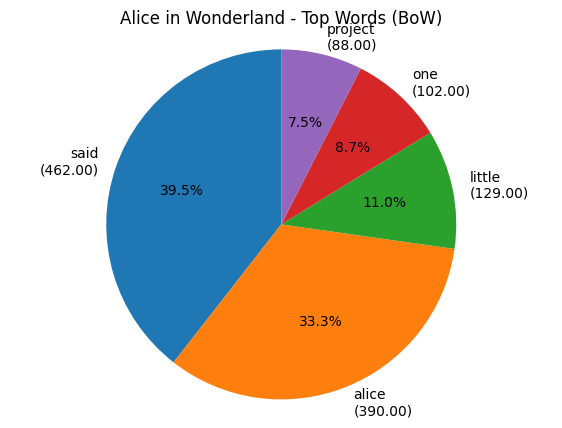

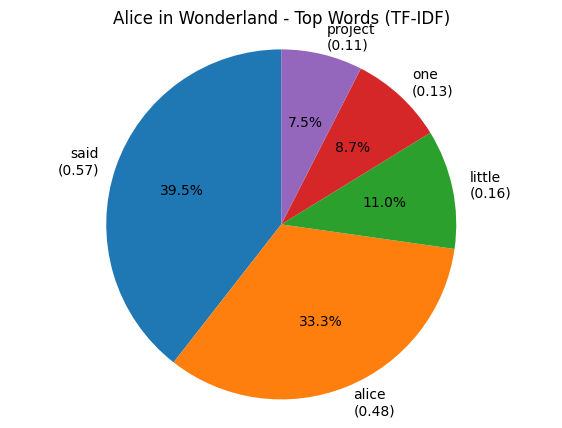

In [121]:
urls = [
    "https://www.gutenberg.org/cache/epub/11/pg11.txt",
]
titles = [
    "Alice in Wonderland",
]

# 🔄 Pipeline complet
texts = load_texts(urls)
texts_clean = extract_main_content(texts)

tokens = tokenize_texts(texts_clean)
tokens_no_stop = remove_stopwords(tokens)

# Join tokens back into strings for vectorizers
processed_texts = [" ".join(doc_tokens) for doc_tokens in tokens_no_stop]


stemmed = stem_tokens(tokens_no_stop)
lemmatized = lemmatize_tokens(texts_clean)

create_wordcloud(lemmatized, titles)

pos = get_pos_tags(tokens_no_stop)
entities = get_entities(texts_clean)

# Pass the joined strings to the vectorizer functions
bow_top = get_bow_top_words(processed_texts)
tfidf_top = get_tfidf_top_words(processed_texts)


for i, title in enumerate(titles):
    create_pie_chart(bow_top[i], title, method="BoW")
    create_pie_chart(tfidf_top[i], title, method="TF-IDF")

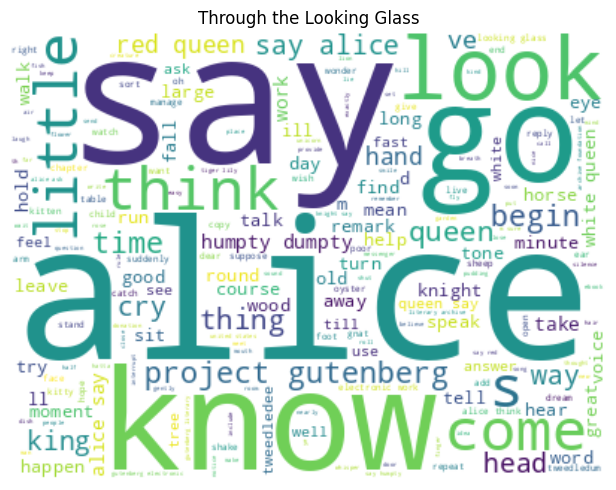

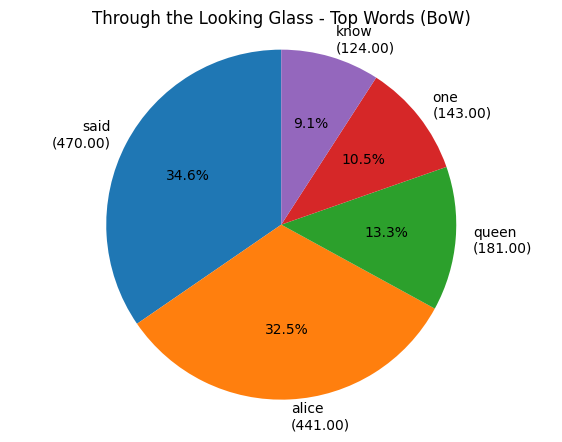

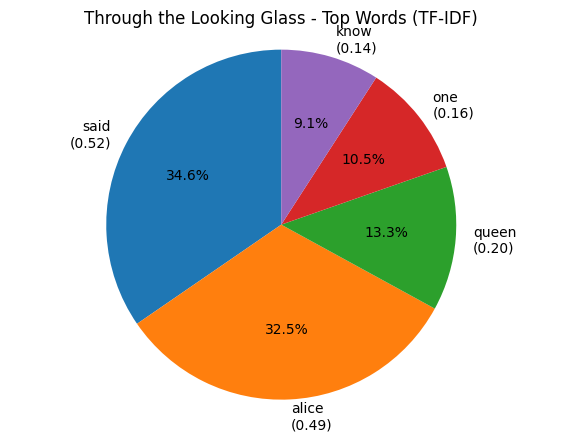

In [122]:
urls = [
    "https://www.gutenberg.org/cache/epub/12/pg12.txt",
]
titles = [
    "Through the Looking Glass",
]

# 🔄 Pipeline complet
texts = load_texts(urls)
texts_clean = extract_main_content(texts)

tokens = tokenize_texts(texts_clean)
tokens_no_stop = remove_stopwords(tokens)

# Join tokens back into strings for vectorizers
processed_texts = [" ".join(doc_tokens) for doc_tokens in tokens_no_stop]


stemmed = stem_tokens(tokens_no_stop)
lemmatized = lemmatize_tokens(texts_clean)

create_wordcloud(lemmatized, titles)

pos = get_pos_tags(tokens_no_stop)
entities = get_entities(texts_clean)

# Pass the joined strings to the vectorizer functions
bow_top = get_bow_top_words(processed_texts)
tfidf_top = get_tfidf_top_words(processed_texts)


for i, title in enumerate(titles):
    create_pie_chart(bow_top[i], title, method="BoW")
    create_pie_chart(tfidf_top[i], title, method="TF-IDF")

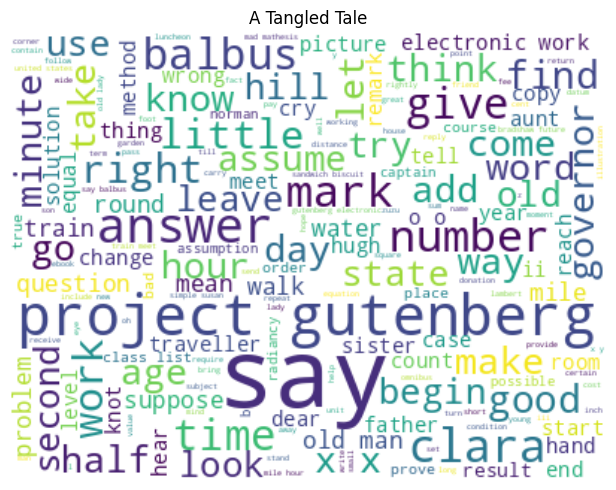

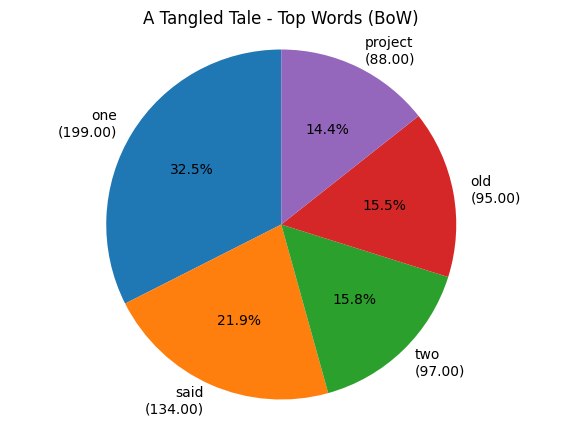

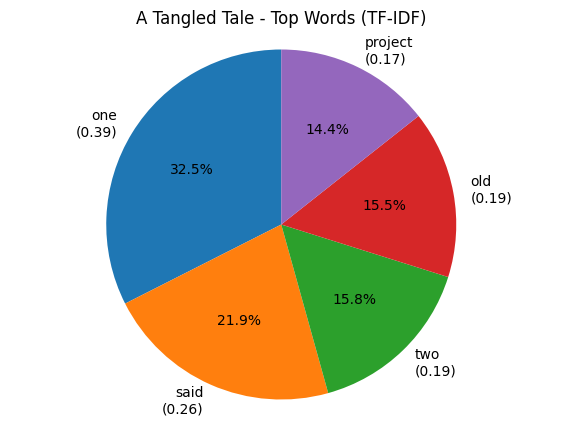

In [124]:
urls = [
    "https://www.gutenberg.org/cache/epub/29042/pg29042.txt"
]
titles = [
    "A Tangled Tale"
]

# 🔄 Pipeline complet
texts = load_texts(urls)
texts_clean = extract_main_content(texts)

tokens = tokenize_texts(texts_clean)
tokens_no_stop = remove_stopwords(tokens)

# Join tokens back into strings for vectorizers
processed_texts = [" ".join(doc_tokens) for doc_tokens in tokens_no_stop]


stemmed = stem_tokens(tokens_no_stop)
lemmatized = lemmatize_tokens(texts_clean)

create_wordcloud(lemmatized, titles)

pos = get_pos_tags(tokens_no_stop)
entities = get_entities(texts_clean)

# Pass the joined strings to the vectorizer functions
bow_top = get_bow_top_words(processed_texts)
tfidf_top = get_tfidf_top_words(processed_texts)


for i, title in enumerate(titles):
    create_pie_chart(bow_top[i], title, method="BoW")
    create_pie_chart(tfidf_top[i], title, method="TF-IDF")

✅ Résumé : À quoi servent toutes ces étapes ?
Étape/But
Télécharger texte/Accéder au corpus
Nettoyage/Éliminer le bruit
Tokenisation/Découper le texte en mots
Stopwords/Enlever les mots peu utiles
Stemming/Lemmatization	Réduction des mots
POS tagging/Comprendre la grammaire
NER/Identifier les noms
Wordcloud/Visualisation simple
BoW/Compter les mots
TF-IDF/Évaluer l'importance des mots

Il faudrait filter de manière plus poussée la fin des ebooks, le projet Gutenberg est énormement cité. Cela le fait apparaître en mots importants.